<a href="https://colab.research.google.com/github/upadhyayprakash/eva4/blob/master/S7/EVA4_Session_7_CIFAR10_Modular.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Session-7 Assignment**
I. Make the [code](https://colab.research.google.com/drive/1qlewMtxcAJT6fIJdmMh8pSf2e-dh51Rw) Modular. Points to ponder:
1. Use GPU - Data and Model porting to GPU during training
2. Separation of Concern - load modules from different files
3. Easy to understand Program flow - Call network artifacts in main program
4. Readability with Comments(wherever necessary) - Explain the purpose of each code cell

II. Optimization:
1. change the code such that it uses GPU
2. change the architecture to C1C2C3C40 (basically 3 MPs)
3. total RF(Receptive Fields) must be more than 44
4. one of the layers must use Depthwise Separable Convolution
5. one of the layers must use Dilated Convolution
6. Use GAP (compulsory):- add FC after GAP to target # of classes (optional)
achieve 80% accuracy, as many epochs as you want. Total Params to be less than 1M. 
7. upload to Github


#### **RESULT**
GitHub Source: https://github.com/upadhyayprakash/eva4/tree/master/S7


#### Loading the Libraries

In [0]:
# Setting up the module import directory
import sys
sys.path.insert(1, '/home/prakash/Prakash/EVA4/Session-7/Notebooks')

In [0]:
# for inline graph plotting
%matplotlib inline

import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torchsummary import summary

#### Checking if GPU(CUDA) is supported

In [3]:
cuda = torch.cuda.is_available() # returns True/False
print('GPU Available?', cuda)

GPU Available? True


#### Loading and Transforming the CIFAR10 Dataset

In [4]:
# MODULES: Train and Test Data Loaders modules

import data_loader
trainloader = data_loader.getTrainLoader('CIFAR10')
testloader = data_loader.getTrainLoader('CIFAR10')
classes = data_loader.getClasses('CIFAR10')

print('Classes: ')
print(classes)

GPU Available? True
Files already downloaded and verified
Files already downloaded and verified
Classes: 
('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


#### Visualize the training data

Batch Grid


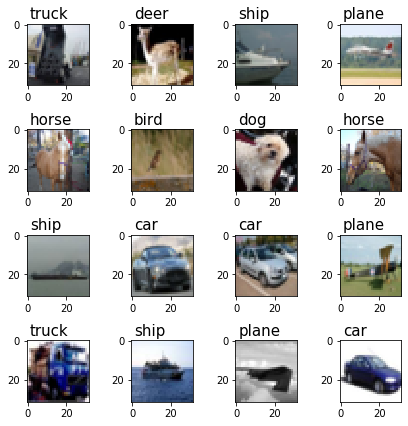

In [5]:
import visualize_data

visualize_data.visualize_batch(trainloader, classes)

In [6]:
cuda = torch.cuda.is_available() # returns True/False
print('CUDA Available?', cuda)

# initiate the Network
device = torch.device("cuda" if cuda else "cpu")

CUDA Available? True


### Creating the Network Object

In [7]:
# Loading the Network
from network import Net

net = Net().to(device)
summary(net, input_size=(3, 32, 32)) # Network Summary

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 30, 30]           3,456
              ReLU-2          [-1, 128, 30, 30]               0
       BatchNorm2d-3          [-1, 128, 30, 30]             256
           Dropout-4          [-1, 128, 30, 30]               0
         MaxPool2d-5          [-1, 128, 15, 15]               0
            Conv2d-6          [-1, 256, 11, 11]         294,912
              ReLU-7          [-1, 256, 11, 11]               0
       BatchNorm2d-8          [-1, 256, 11, 11]             512
           Dropout-9          [-1, 256, 11, 11]               0
        MaxPool2d-10            [-1, 256, 5, 5]               0
           Conv2d-11            [-1, 256, 5, 5]             256
           Conv2d-12            [-1, 128, 5, 5]          32,768
             ReLU-13            [-1, 128, 5, 5]               0
      BatchNorm2d-14            [-1, 12

#### Defining Loss function and Optimizer

In [0]:
# Loss Function
criterion = nn.CrossEntropyLoss()

### Training Program

In [9]:
# Model Trainer
import model_trainer
EPOCHS = 8
model = model_trainer.train_model(net, EPOCHS, device, trainloader, criterion)

EPOCH: 1
[1,  2000] loss: 1.760
EPOCH: 2
[2,  2000] loss: 1.484
EPOCH: 3
[3,  2000] loss: 1.384
EPOCH: 4
[4,  2000] loss: 1.315
EPOCH: 5
[5,  2000] loss: 1.265
EPOCH: 6
[6,  2000] loss: 1.220
EPOCH: 7
[7,  2000] loss: 1.094
EPOCH: 8
[8,  2000] loss: 1.060
Finished Training


#### Ground Truth Visualization

### Evaluating the model

cuda
Batch Grid
Accuracy of the network on the 10000 test images: 64 %
Test Result & Ground Truth
{'predicted_labels': [['car', 'cat', 'ship', 'bird', 'ship', 'cat', 'dog', 'ship', 'horse', 'horse', 'ship', 'bird', 'dog', 'car', 'cat', 'truck'], ['horse', 'horse', 'dog', 'car', 'horse', 'truck', 'car', 'truck', 'bird', 'horse', 'cat', 'ship', 'plane', 'deer', 'frog', 'bird'], ['truck', 'horse', 'bird', 'ship', 'truck', 'horse', 'frog', 'ship', 'bird', 'frog', 'car', 'horse', 'truck', 'bird', 'horse', 'truck'], ['ship', 'dog', 'cat', 'horse', 'cat', 'dog', 'truck', 'bird', 'truck', 'horse', 'ship', 'plane', 'frog', 'dog', 'bird', 'truck'], ['car', 'truck', 'plane', 'horse', 'deer', 'truck', 'bird', 'deer', 'truck', 'deer', 'ship', 'horse', 'frog', 'deer', 'truck', 'bird'], ['deer', 'car', 'dog', 'cat', 'truck', 'car', 'car', 'cat', 'dog', 'frog', 'plane', 'frog', 'horse', 'car', 'bird', 'horse'], ['truck', 'truck', 'dog', 'ship', 'car', 'car', 'plane', 'truck', 'deer', 'horse', 'horse',

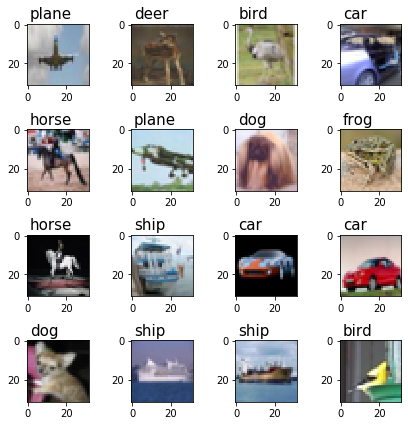

In [12]:
import testing
print(device)
# result = testing.test(model, device, testloader, criterion, classes)
result = testing.test(model, device, testloader, classes)
print('Test Result & Ground Truth')
print(result)

### Class-wise Evaluation Result

In [11]:
import class_wise_results

class_wise_results.show_class_wise_results(model, testloader, device, classes)

Accuracy of plane : 66 %
Accuracy of   car : 76 %
Accuracy of  bird : 51 %
Accuracy of   cat : 52 %
Accuracy of  deer : 62 %
Accuracy of   dog : 56 %
Accuracy of  frog : 74 %
Accuracy of horse : 70 %
Accuracy of  ship : 64 %
Accuracy of truck : 75 %
